## Importing libraries

In [1]:
import json
import re
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM

pd.set_option('display.max_colwidth', 200)

In [2]:
### to ignore future warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the News Dataset

In [3]:
data = pd.read_csv("Updatedd.csv", encoding='utf-8')

In [20]:
### to see the information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23997 entries, 0 to 23996
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  23997 non-null  object
 1   article   23997 non-null  object
dtypes: object(2)
memory usage: 375.1+ KB


In [5]:
### to check the total number of rows or number of sentences
data.shape ### 50479 rows in 2 different columns

(16000, 2)

In [6]:
### to retrieve the first 30 rows
data.head(30)

,category,article
0,የሃገር ዉስጥ ዜና,የኢትዮጵያ የፖለቲካ ፓርቲዎች የጋራ ምክር ቤት የአገሪቱ የሰላም ሁኔታ የከፋ ቀውስ ውስጥ መሆኑን በመግለጽ የሰጠውን መግለጫ ተቃውመው ሌላ ጋዜጣዊ መግለጫ በሰጡ ፓርቲዎች ላይ፣ የቅጣት ዕርምጃ የሚያስከትል የዲሲፕሊን ምርመራ መጀመሩን አስታወቀ።
1,የሃገር ዉስጥ ዜና,በሕዝበ ውሳኔው ስድስት ወራት ያልሞላው መታወቂያ የያዙ በርካታ መራጮች ተገኝተዋል በወላይታ ዞን በተካሄደ ድጋሚ ሕዝበ ውሳኔ በርካታ ባዶ መታወቂያዎች ድምፅ ለሚሰጡ ሰዎች ለማደል አስቦ በመንቀሳቀስ የነበረ እንድ ግለሰብ እጅ ከፍንጅ መያዙ ተገለጸ፡፡
2,የሃገር ዉስጥ ዜና,የዓለም አቀፉ የአየር ትራንስፖርት ማኅበር (IATA)፣ የኢትዮጵያ መንግሥት እስካሁን ለውጭ አየር መንገዶች ያልከፈለውን 95 ሚሊዮን ዶላር የተከማቸ ዕዳ በአስቸኳይ እንዲከፍል ጠየቀ፡፡
3,የሃገር ዉስጥ ዜና,በኢትዮጵያ ከ12 ሚሊዮን በላይ ወገኖች ከፍተኛ የምግብ እጥረት መጋለጣቸውን፣ የብሔራዊ አደጋ ሥጋት ሥራ አመራር ኮሚሽን ለሪፖርተር አስታወቀ፡
4,የሃገር ዉስጥ ዜና,በኢትዮጵያ የቻይና አምባሳደር ዣኦ ዚዩዋን በትግራይ ክልል የተቋረጡ በቻይና መንግሥት ፋይናንስ የሚደገፉ ፕሮጀክቶችን እንደገና ለመጀመር፣ መንግሥታቸውን ፍላጎት እንዳለው አስታወቁ፡፡
5,የሃገር ዉስጥ ዜና,የፌዴራል መንግሥት ከክልሎች እንዲሁም በክልሎች መካከል የሚደረገው የመንግሥታት ግንኙነት፣ በፓርቲ መስመር እንዳይደፈጠጥ ትኩረት እንዲደረግ ጥያቄ ቀረበ።
6,የሃገር ዉስጥ ዜና,ለግብርና ምርታማነት አስተዋፅኦ የሚያደርጉ የእርሻና የአግሮ ኢንዱስትሪ ቴክኖሎጂዎችንና ግብዓቶችን የሚያቀርበው የኢትዮጵያ ግብርና ሥራዎች ኮርፖሬሽን፣ የተፈቀደ ካፒታሉን ወደ 7.5 ቢሊዮን ብር ለማሳደግ ያቀረበው ጥያቄ ይሁንታ ሊያገኝ እንደሆነ አስታወቀ፡፡
7,የሃገር ዉስጥ ዜና,በዳንኤል ንጉሤ በሰሜን ኢትዮጵያ ጦርነት ወቅት ከፍተኛ ጉዳት ለደረሰበት የአክሱም አውሮፕላን ማረፊያ መልሶ ግንባታ ከ200 ሚሊዮን ብር በላይ በጀት መመደቡን፣ የኢትዮጵያ አየር መንገድ ግሩፕ ዋና ሥራ አስፈጻሚ አቶ መስፍን ጣሰው ለሪፖርተር አስታወቁ።
8,የሃገር ዉስጥ ዜና,በአገር አቀፍ ደረጃ ኮንዶም እየቀረበ ያለው ለኤችአይቪ/ኤድስ ይበልጥ ተጋላጭ ተብለው ለተለዩ የኅብረተሰብ ክፍሎች ብቻ መሆኑን፣ የጤና ሚኒስቴር አስታወቀ፡፡
9,የሃገር ዉስጥ ዜና,"የእንግሊዝ መንግሥት ኢትዮጵያ የዓለም ንግድ ድርጅት አባል ለመሆን ለምታደርገው ሁሉን አቀፍ ዝግጅት፣ የ450,000 ፓውንድ ድጋፍ ማድረጉን አስታወቀ፡፡"


### Checking the News catagories

In [4]:
data["category"].value_counts()

የሃገር ዉስጥ ዜና    4000
ፖለቲካ           4000
ቢዝነስ           4000
ስፖርት           4000
መዝናኛ           3999
አለምአቀፋዊ ዜና     3998
Name: category, dtype: int64

In [5]:
data["category"].unique()

array(['የሃገር ዉስጥ ዜና', 'ፖለቲካ', 'ቢዝነስ', 'አለምአቀፋዊ ዜና', 'መዝናኛ', 'ስፖርት'],
      dtype=object)

In [ ]:
##the above output shows the category has a nan or missing values, so we have to remove these missing values

### Removing any missing value from  the whole dataset

In [6]:
data_new = data.dropna()

In [6]:
data_new.head()

,category,article
0,የሃገር ዉስጥ ዜና,የኢትዮጵያ የፖለቲካ ፓርቲዎች የጋራ ምክር ቤት የአገሪቱ የሰላም ሁኔታ የከፋ ቀውስ ውስጥ መሆኑን በመግለጽ የሰጠውን መግለጫ ተቃውመው ሌላ ጋዜጣዊ መግለጫ በሰጡ ፓርቲዎች ላይ፣ የቅጣት ዕርምጃ የሚያስከትል የዲሲፕሊን ምርመራ መጀመሩን አስታወቀ።
1,የሃገር ዉስጥ ዜና,በሕዝበ ውሳኔው ስድስት ወራት ያልሞላው መታወቂያ የያዙ በርካታ መራጮች ተገኝተዋል በወላይታ ዞን በተካሄደ ድጋሚ ሕዝበ ውሳኔ በርካታ ባዶ መታወቂያዎች ድምፅ ለሚሰጡ ሰዎች ለማደል አስቦ በመንቀሳቀስ የነበረ እንድ ግለሰብ እጅ ከፍንጅ መያዙ ተገለጸ፡፡
2,የሃገር ዉስጥ ዜና,የዓለም አቀፉ የአየር ትራንስፖርት ማኅበር (IATA)፣ የኢትዮጵያ መንግሥት እስካሁን ለውጭ አየር መንገዶች ያልከፈለውን 95 ሚሊዮን ዶላር የተከማቸ ዕዳ በአስቸኳይ እንዲከፍል ጠየቀ፡፡
3,የሃገር ዉስጥ ዜና,በኢትዮጵያ ከ12 ሚሊዮን በላይ ወገኖች ከፍተኛ የምግብ እጥረት መጋለጣቸውን፣ የብሔራዊ አደጋ ሥጋት ሥራ አመራር ኮሚሽን ለሪፖርተር አስታወቀ፡
4,የሃገር ዉስጥ ዜና,በኢትዮጵያ የቻይና አምባሳደር ዣኦ ዚዩዋን በትግራይ ክልል የተቋረጡ በቻይና መንግሥት ፋይናንስ የሚደገፉ ፕሮጀክቶችን እንደገና ለመጀመር፣ መንግሥታቸውን ፍላጎት እንዳለው አስታወቁ፡፡


### Counting the unique catagories after removing missing values

In [7]:
data_new.category.dropna()

0        የሃገር ዉስጥ ዜና
1        የሃገር ዉስጥ ዜና
2        የሃገር ዉስጥ ዜና
3        የሃገር ዉስጥ ዜና
4        የሃገር ዉስጥ ዜና
            ...     
23992           ፖለቲካ
23993           ፖለቲካ
23994           ፖለቲካ
23995           ፖለቲካ
23996           ፖለቲካ
Name: category, Length: 23997, dtype: object

In [8]:
data_new.category.unique() ### nan will be removed

array(['የሃገር ዉስጥ ዜና', 'ፖለቲካ', 'ቢዝነስ', 'አለምአቀፋዊ ዜና', 'መዝናኛ', 'ስፖርት'],
      dtype=object)

### Counting the links of the articles


In [ ]:
data_new['link'].value_counts()

In [ ]:
data_new['link'].unique()

In [ ]:
data_new.shape ### the output shows the the number of rows also decreased after removing missing values

### Plotting the category graph

In [9]:
data_new.category.dropna()

0        የሃገር ዉስጥ ዜና
1        የሃገር ዉስጥ ዜና
2        የሃገር ዉስጥ ዜና
3        የሃገር ዉስጥ ዜና
4        የሃገር ዉስጥ ዜና
            ...     
23992           ፖለቲካ
23993           ፖለቲካ
23994           ፖለቲካ
23995           ፖለቲካ
23996           ፖለቲካ
Name: category, Length: 23997, dtype: object

In [74]:
import seaborn as sn

In [75]:
font_name = "Nyala"
try:
    sn.set(font=font_name)
    sn.countplot(data_new.category)
    plt.show()
except ValueError:
    raise

ValueError: could not convert string to float: 'የሃገር ዉስጥ ዜና'

### Calculating Word length

In [10]:
data_new['word_length'] = data_new['article'].apply(lambda x:len(x.split()))

In [30]:
data_new.head()

,category,article,word_length
0,የሃገር ዉስጥ ዜና,የኢትዮጵያ የፖለቲካ ፓርቲዎች የጋራ ምክር ቤት የአገሪቱ የሰላም ሁኔታ የከፋ ቀውስ ውስጥ መሆኑን በመግለጽ የሰጠውን መግለጫ ተቃውመው ሌላ ጋዜጣዊ መግለጫ በሰጡ ፓርቲዎች ላይ፣ የቅጣት ዕርምጃ የሚያስከትል የዲሲፕሊን ምርመራ መጀመሩን አስታወቀ።,30
1,የሃገር ዉስጥ ዜና,በሕዝበ ውሳኔው ስድስት ወራት ያልሞላው መታወቂያ የያዙ በርካታ መራጮች ተገኝተዋል በወላይታ ዞን በተካሄደ ድጋሚ ሕዝበ ውሳኔ በርካታ ባዶ መታወቂያዎች ድምፅ ለሚሰጡ ሰዎች ለማደል አስቦ በመንቀሳቀስ የነበረ እንድ ግለሰብ እጅ ከፍንጅ መያዙ ተገለጸ፡፡,32
2,የሃገር ዉስጥ ዜና,የዓለም አቀፉ የአየር ትራንስፖርት ማኅበር (IATA)፣ የኢትዮጵያ መንግሥት እስካሁን ለውጭ አየር መንገዶች ያልከፈለውን 95 ሚሊዮን ዶላር የተከማቸ ዕዳ በአስቸኳይ እንዲከፍል ጠየቀ፡፡,21
3,የሃገር ዉስጥ ዜና,በኢትዮጵያ ከ12 ሚሊዮን በላይ ወገኖች ከፍተኛ የምግብ እጥረት መጋለጣቸውን፣ የብሔራዊ አደጋ ሥጋት ሥራ አመራር ኮሚሽን ለሪፖርተር አስታወቀ፡,17
4,የሃገር ዉስጥ ዜና,በኢትዮጵያ የቻይና አምባሳደር ዣኦ ዚዩዋን በትግራይ ክልል የተቋረጡ በቻይና መንግሥት ፋይናንስ የሚደገፉ ፕሮጀክቶችን እንደገና ለመጀመር፣ መንግሥታቸውን ፍላጎት እንዳለው አስታወቁ፡፡,19


In [11]:
### mean of the word length
data_new.word_length.mean()

22.061382672834103

In [12]:
### maximum of the word length
data_new.word_length.max()

75

In [ ]:
### droping 'headline','date','views','link', they are unnecessary columns
data_new=data_new.drop(['headline','date','views','link'],axis=1)

In [ ]:
display(data_new.head())

### Plotting word length

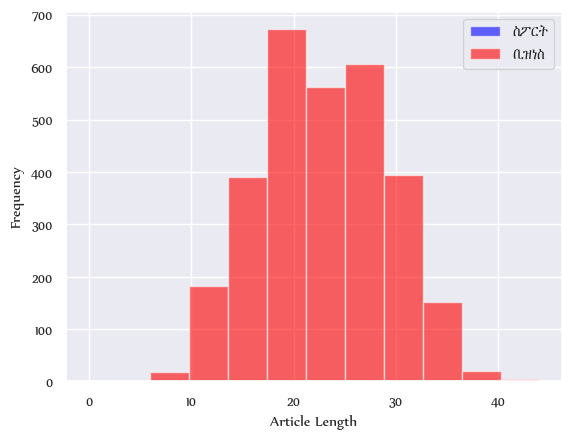

In [28]:
data_new[data_new.category=='ስፖርት'].word_length.plot(bins=35, kind='hist', color='blue', label='ስፖርት', alpha=0.6)
data_new[data_new.category=='ቢዝነስ'].word_length.plot(kind='hist', color='red', label='ቢዝነስ', alpha=0.6)
plt.legend()
plt.xlabel('Article Length')
plt.show()

In [29]:
## Average word length in each category
data_new.groupby('category').mean()

,word_length
category,
መዝናኛ,22.286429
ቢዝነስ,22.852000
አለምአቀፋዊ ዜና,25.384667
የሃገር ዉስጥ ዜና,21.876000
ፖለቲካ,24.413333


### Describing each category

In [30]:
### ስፖርት category
data_new[data_new.category=='ስፖርት'].describe()

,word_length
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [31]:
### መዝናኛ category
data_new[data_new.category == 'ቢዝነስ'].describe()

,word_length
count,3000.000000
mean,22.852000
std,6.034366
min,6.000000
25%,19.000000
50%,23.000000
75%,27.000000
max,44.000000


In [ ]:
### ሀገር አቀፍ ዜና category
data_new[data_new.category == 'ሀገር አቀፍ ዜና'].describe()

In [ ]:
### ሀገር አቀፍ ዜና category
data_new[data_new.category == 'ዓለም አቀፍ ዜና'].describe()

### Preprocessing the texts

#### 1. Normalization
To normalize character level missmatch such as "ጸሀይ" and "ፀሐይ" and others

In [13]:
import re
def normalize_char_level_missmatch(input_token):
    rep1=re.sub('[ሃኅኃሐሓኻ]','ሀ',input_token)
    rep2=re.sub('[ሑኁዅ]','ሁ',rep1)
    rep3=re.sub('[ኂሒኺ]','ሂ',rep2)
    rep4=re.sub('[ኌሔዄ]','ሄ',rep3)
    rep5=re.sub('[ሕኅ]','ህ',rep4)
    rep6=re.sub('[ኆሖኾ]','ሆ',rep5)
    rep7=re.sub('[ሠ]','ሰ',rep6)
    rep8=re.sub('[ሡ]','ሱ',rep7)
    rep9=re.sub('[ሢ]','ሲ',rep8)
    rep10=re.sub('[ሣ]','ሳ',rep9)
    rep11=re.sub('[ሤ]','ሴ',rep10)
    rep12=re.sub('[ሥ]','ስ',rep11)
    rep13=re.sub('[ሦ]','ሶ',rep12)
    rep14=re.sub('[ዓኣዐ]','አ',rep13)
    rep15=re.sub('[ዑ]','ኡ',rep14)
    rep16=re.sub('[ዒ]','ኢ',rep15)
    rep17=re.sub('[ዔ]','ኤ',rep16)
    rep18=re.sub('[ዕ]','እ',rep17)
    rep19=re.sub('[ዖ]','ኦ',rep18)
    rep20=re.sub('[ጸ]','ፀ',rep19)
    rep21=re.sub('[ጹ]','ፁ',rep20)
    rep22=re.sub('[ጺ]','ፂ',rep21)
    rep23=re.sub('[ጻ]','ፃ',rep22)
    rep24=re.sub('[ጼ]','ፄ',rep23)
    rep25=re.sub('[ጽ]','ፅ',rep24)
    rep26=re.sub('[ጾ]','ፆ',rep25)
    #Normalizing words with Labialized Amharic characters such as በልቱዋል or  በልቱአል to  በልቷል  
    rep27=re.sub('(ሉ[ዋአ])','ሏ',rep26)
    rep28=re.sub('(ሙ[ዋአ])','ሟ',rep27)
    rep29=re.sub('(ቱ[ዋአ])','ቷ',rep28)
    rep30=re.sub('(ሩ[ዋአ])','ሯ',rep29)
    rep31=re.sub('(ሱ[ዋአ])','ሷ',rep30)
    rep32=re.sub('(ሹ[ዋአ])','ሿ',rep31)
    rep33=re.sub('(ቁ[ዋአ])','ቋ',rep32)
    rep34=re.sub('(ቡ[ዋአ])','ቧ',rep33)
    rep35=re.sub('(ቹ[ዋአ])','ቿ',rep34)
    rep36=re.sub('(ሁ[ዋአ])','ኋ',rep35)
    rep37=re.sub('(ኑ[ዋአ])','ኗ',rep36)
    rep38=re.sub('(ኙ[ዋአ])','ኟ',rep37)
    rep39=re.sub('(ኩ[ዋአ])','ኳ',rep38)
    rep40=re.sub('(ዙ[ዋአ])','ዟ',rep39)
    rep41=re.sub('(ጉ[ዋአ])','ጓ',rep40)
    rep42=re.sub('(ደ[ዋአ])','ዷ',rep41)
    rep43=re.sub('(ጡ[ዋአ])','ጧ',rep42)
    rep44=re.sub('(ጩ[ዋአ])','ጯ',rep43)
    rep45=re.sub('(ጹ[ዋአ])','ጿ',rep44)
    rep46=re.sub('(ፉ[ዋአ])','ፏ',rep45)
    rep47=re.sub('[ቊ]','ቁ',rep46) #ቁ can be written as ቊ
    rep48=re.sub('[ኵ]','ኩ',rep47) #ኩ can be also written as ኵ  
    return rep48

#### 2. Removing Special Characters
To remove any special charater from the article column

In [14]:
data_new['article'] = data_new['article'].str.replace('[^\w\s]','')

In [15]:
### Applying the normalize_char_level_missmatch method
data_new['article'] = data_new['article'].apply(lambda x: normalize_char_level_missmatch(x))

In [16]:
n_data = data_new[['article','category']]
n_data.head()

,article,category
0,የኢትዮጵያ የፖለቲካ ፓርቲዎች የጋራ ምክር ቤት የአገሪቱ የሰላም ሁኔታ የከፋ ቀውስ ውስጥ መሆኑን በመግለፅ የሰጠውን መግለጫ ተቃውመው ሌላ ጋዜጣዊ መግለጫ በሰጡ ፓርቲዎች ላይ የቅጣት እርምጃ የሚያስከትል የዲሲፕሊን ምርመራ መጀመሩን አስታወቀ,የሃገር ዉስጥ ዜና
1,በህዝበ ውሳኔው ስድስት ወራት ያልሞላው መታወቂያ የያዙ በርካታ መራጮች ተገኝተዋል በወላይታ ዞን በተካሄደ ድጋሚ ህዝበ ውሳኔ በርካታ ባዶ መታወቂያዎች ድምፅ ለሚሰጡ ሰዎች ለማደል አስቦ በመንቀሳቀስ የነበረ እንድ ግለሰብ እጅ ከፍንጅ መያዙ ተገለፀ,የሃገር ዉስጥ ዜና
2,የአለም አቀፉ የአየር ትራንስፖርት ማሀበር IATA የኢትዮጵያ መንግስት እስካሁን ለውጭ አየር መንገዶች ያልከፈለውን 95 ሚሊዮን ዶላር የተከማቸ እዳ በአስቸኳይ እንዲከፍል ጠየቀ,የሃገር ዉስጥ ዜና
3,በኢትዮጵያ ከ12 ሚሊዮን በላይ ወገኖች ከፍተኛ የምግብ እጥረት መጋለጣቸውን የብሄራዊ አደጋ ስጋት ስራ አመራር ኮሚሽን ለሪፖርተር አስታወቀ,የሃገር ዉስጥ ዜና
4,በኢትዮጵያ የቻይና አምባሳደር ዣኦ ዚዩዋን በትግራይ ክልል የተቋረጡ በቻይና መንግስት ፋይናንስ የሚደገፉ ፕሮጀክቶችን እንደገና ለመጀመር መንግስታቸውን ፍላጎት እንዳለው አስታወቁ,የሃገር ዉስጥ ዜና


In [17]:
text,label = data_new['article'].values,data_new['category'].values

In [18]:
label

array(['የሃገር ዉስጥ ዜና', 'የሃገር ዉስጥ ዜና', 'የሃገር ዉስጥ ዜና', ..., 'ፖለቲካ', 'ፖለቲካ',
       'ፖለቲካ'], dtype=object)

#### 3. Removing Stopwords
Removing the stopwords from the article column using the set Amharic stopwords

In [19]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words('Amharic.txt'))
stop_words

{'ሀ',
 'ሀሙስ',
 'ሁለቱም',
 'ሁሉ',
 'ሁሉም',
 'ሁን',
 'ለ',
 'ለመሆን',
 'ለምን',
 'ላይ',
 'ሌላ',
 'ሕዝብ',
 'መ',
 'መሆን',
 'መስራት',
 'መቼ',
 'መካከል',
 'ማን',
 'ማንኛውም',
 'ማድረግ',
 'ም',
 'ምንድን',
 'ምክንያቱም',
 'ራሱ',
 'ራሳቸው',
 'ራስህን',
 'ስለ',
 'ስለዚህ',
 'ቆይቷል',
 'በ',
 'በላይ',
 'በኋላ',
 'በኩል',
 'በጣም',
 'ብቻ',
 'ተመሳሳይ',
 'ተጨማሪ',
 'ታች',
 'ት',
 'ትፈልጋለህ',
 'ነህ',
 'ነበረው',
 'ነበሩ',
 'ነበር',
 'ነኝ',
 'ነው',
 'ናቸው',
 'አሁን',
 'አለው',
 'አላቸው',
 'አላችሁ',
 'አንቺ',
 'አንዳንድ',
 'አንድ',
 'አንድ ጊዜ',
 'አደረገ',
 'እራሳችሁ',
 'እራሷ',
 'እርስዎ',
 'እሱ',
 'እስከ',
 'እሷ',
 'እሷናት',
 'እነሱ',
 'እነሱን',
 'እነዚህ',
 'እነዚያ',
 'እና',
 'እኔ',
 'እኔ ራሴ',
 'እንደ',
 'እንደዚህ',
 'እንደገና',
 'እንዲሁ',
 'እንዴት',
 'እኛ',
 'እኛ ራሳችን',
 'እዚህ',
 'እዚያ',
 'እያለ',
 'እያንዳንዳቸው',
 'ኦ',
 'ከ',
 'ከሆነ',
 'ከላይ',
 'ከታች',
 'ከዚህ በፊት',
 'ከዚያ',
 'ወቅት',
 'ወይም',
 'ወደ',
 'ወደ ላይ',
 'ውስጥ',
 'ውጭ',
 'የ',
 'የሚል ነው',
 'የራሱ',
 'የት',
 'የትኛው',
 'የእሱ',
 'የእሷ',
 'የእነሱ',
 'የእኔ',
 'የእኛ',
 'ያ',
 'ያለው',
 'ያንተ',
 'ያደርጋል',
 'ይህ',
 'ይልቅ',
 'ይችላል',
 'ይገባል',
 'ይገባኛል',
 'ዳግም',
 'ጋር',
 'ጥቂቶች'}

In [20]:
import nltk
from nltk.tokenize import word_tokenize
def remove_stopwords(sentence):
    word_tokens = word_tokenize(sentence)  
    clean_tokens = [w for w in word_tokens if not w in stop_words]  
    
    return clean_tokens

In [21]:
data_new_stopwords_removed = data_new['article'].apply(remove_stopwords)
data_new

,category,article,word_length
0,የሃገር ዉስጥ ዜና,የኢትዮጵያ የፖለቲካ ፓርቲዎች የጋራ ምክር ቤት የአገሪቱ የሰላም ሁኔታ የከፋ ቀውስ ውስጥ መሆኑን በመግለፅ የሰጠውን መግለጫ ተቃውመው ሌላ ጋዜጣዊ መግለጫ በሰጡ ፓርቲዎች ላይ የቅጣት እርምጃ የሚያስከትል የዲሲፕሊን ምርመራ መጀመሩን አስታወቀ,30
1,የሃገር ዉስጥ ዜና,በህዝበ ውሳኔው ስድስት ወራት ያልሞላው መታወቂያ የያዙ በርካታ መራጮች ተገኝተዋል በወላይታ ዞን በተካሄደ ድጋሚ ህዝበ ውሳኔ በርካታ ባዶ መታወቂያዎች ድምፅ ለሚሰጡ ሰዎች ለማደል አስቦ በመንቀሳቀስ የነበረ እንድ ግለሰብ እጅ ከፍንጅ መያዙ ተገለፀ,32
2,የሃገር ዉስጥ ዜና,የአለም አቀፉ የአየር ትራንስፖርት ማሀበር IATA የኢትዮጵያ መንግስት እስካሁን ለውጭ አየር መንገዶች ያልከፈለውን 95 ሚሊዮን ዶላር የተከማቸ እዳ በአስቸኳይ እንዲከፍል ጠየቀ,21
3,የሃገር ዉስጥ ዜና,በኢትዮጵያ ከ12 ሚሊዮን በላይ ወገኖች ከፍተኛ የምግብ እጥረት መጋለጣቸውን የብሄራዊ አደጋ ስጋት ስራ አመራር ኮሚሽን ለሪፖርተር አስታወቀ,17
4,የሃገር ዉስጥ ዜና,በኢትዮጵያ የቻይና አምባሳደር ዣኦ ዚዩዋን በትግራይ ክልል የተቋረጡ በቻይና መንግስት ፋይናንስ የሚደገፉ ፕሮጀክቶችን እንደገና ለመጀመር መንግስታቸውን ፍላጎት እንዳለው አስታወቁ,19
...,...,...,...
23992,ፖለቲካ,ከ12 በላይ ምእራባውያን አጋሮች ሩስያውን ቅጥረኛ ተዋጊዎች በማሊ ተሰማርተዋል ሲሉ አወገዙ,11
23993,ፖለቲካ,ላለፉት ሶስት ወራት ገደማ በእስር ላይ የቆዩት የአረና ትግራይ ፓርቲ ሊቀመንበርና የቀድሞው የትግራይ ጊዜያዊ አስተዳደር አመራር የነበሩት አቶ አብረሀ ደስታ ከእስር ተፈቱ,22
23994,ፖለቲካ,በሆንግ ኮንግ በተደረገው አወዛጋቢ በተባለውና በግዛቱ በታሪክ ዝቅተኛው የመራጮች ቁጥር በታየበት የህግ አውጪ ምክር ቤት ምርጫ የማእከላዊ ቻይና መንግስት ደጋፊ የሆኑ እጩዎች በከፍተኛ ድምፅ ማሸነፋቸውን ገለፁ,26
23995,ፖለቲካ,በሱዳን የተካሄደው ህዝባዊ እንቅስቃሴ ሶስተኛ አመትን ምክንያት በማድረግ ጦር ሰራዊቱ ስልጣን መቆጣጠሩን የመቃወሙ በርካታ ህዝብ የተሳተፈባቸው የተቃውሞ ሰልፎች በመላው ሱዳን ተካሄዱ,21


In [22]:
data_new_stopwords_removed

0                          [የኢትዮጵያ, የፖለቲካ, ፓርቲዎች, የጋራ, ምክር, ቤት, የአገሪቱ, የሰላም, ሁኔታ, የከፋ, ቀውስ, መሆኑን, በመግለፅ, የሰጠውን, መግለጫ, ተቃውመው, ጋዜጣዊ, መግለጫ, በሰጡ, ፓርቲዎች, የቅጣት, እርምጃ, የሚያስከትል, የዲሲፕሊን, ምርመራ, መጀመሩን, አስታወቀ]
1        [በህዝበ, ውሳኔው, ስድስት, ወራት, ያልሞላው, መታወቂያ, የያዙ, በርካታ, መራጮች, ተገኝተዋል, በወላይታ, ዞን, በተካሄደ, ድጋሚ, ህዝበ, ውሳኔ, በርካታ, ባዶ, መታወቂያዎች, ድምፅ, ለሚሰጡ, ሰዎች, ለማደል, አስቦ, በመንቀሳቀስ, የነበረ, እንድ, ግለሰብ, እጅ, ከፍንጅ, መያዙ, ተገለፀ]
2                                                               [የአለም, አቀፉ, የአየር, ትራንስፖርት, ማሀበር, IATA, የኢትዮጵያ, መንግስት, እስካሁን, ለውጭ, አየር, መንገዶች, ያልከፈለውን, 95, ሚሊዮን, ዶላር, የተከማቸ, እዳ, በአስቸኳይ, እንዲከፍል, ጠየቀ]
3                                                                                                [በኢትዮጵያ, ከ12, ሚሊዮን, ወገኖች, ከፍተኛ, የምግብ, እጥረት, መጋለጣቸውን, የብሄራዊ, አደጋ, ስጋት, ስራ, አመራር, ኮሚሽን, ለሪፖርተር, አስታወቀ]
4                                                                        [በኢትዮጵያ, የቻይና, አምባሳደር, ዣኦ, ዚዩዋን, በትግራይ, ክልል, የተቋረጡ, በቻይና, መንግስት, ፋይናንስ, የሚደገፉ, ፕሮጀክቶችን, ለመጀመር, መንግስታቸውን, ፍላጎት, እንዳለው, አስታወቁ]
          

In [23]:
X=data_new_stopwords_removed
y=data_new['category']

In [24]:
### the most mandatory step to convert the news to unique catagories, or encoding the categories
y = np.array(pd.get_dummies(y))

In [25]:
y.shape

(23997, 6)

In [43]:
y

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [26]:
X,y

(0                          [የኢትዮጵያ, የፖለቲካ, ፓርቲዎች, የጋራ, ምክር, ቤት, የአገሪቱ, የሰላም, ሁኔታ, የከፋ, ቀውስ, መሆኑን, በመግለፅ, የሰጠውን, መግለጫ, ተቃውመው, ጋዜጣዊ, መግለጫ, በሰጡ, ፓርቲዎች, የቅጣት, እርምጃ, የሚያስከትል, የዲሲፕሊን, ምርመራ, መጀመሩን, አስታወቀ]
 1        [በህዝበ, ውሳኔው, ስድስት, ወራት, ያልሞላው, መታወቂያ, የያዙ, በርካታ, መራጮች, ተገኝተዋል, በወላይታ, ዞን, በተካሄደ, ድጋሚ, ህዝበ, ውሳኔ, በርካታ, ባዶ, መታወቂያዎች, ድምፅ, ለሚሰጡ, ሰዎች, ለማደል, አስቦ, በመንቀሳቀስ, የነበረ, እንድ, ግለሰብ, እጅ, ከፍንጅ, መያዙ, ተገለፀ]
 2                                                               [የአለም, አቀፉ, የአየር, ትራንስፖርት, ማሀበር, IATA, የኢትዮጵያ, መንግስት, እስካሁን, ለውጭ, አየር, መንገዶች, ያልከፈለውን, 95, ሚሊዮን, ዶላር, የተከማቸ, እዳ, በአስቸኳይ, እንዲከፍል, ጠየቀ]
 3                                                                                                [በኢትዮጵያ, ከ12, ሚሊዮን, ወገኖች, ከፍተኛ, የምግብ, እጥረት, መጋለጣቸውን, የብሄራዊ, አደጋ, ስጋት, ስራ, አመራር, ኮሚሽን, ለሪፖርተር, አስታወቀ]
 4                                                                        [በኢትዮጵያ, የቻይና, አምባሳደር, ዣኦ, ዚዩዋን, በትግራይ, ክልል, የተቋረጡ, በቻይና, መንግስት, ፋይናንስ, የሚደገፉ, ፕሮጀክቶችን, ለመጀመር, መንግስታቸውን, ፍላጎት, እንዳለው, አስታወቁ]
     

In [27]:
data_new

,category,article,word_length
0,የሃገር ዉስጥ ዜና,የኢትዮጵያ የፖለቲካ ፓርቲዎች የጋራ ምክር ቤት የአገሪቱ የሰላም ሁኔታ የከፋ ቀውስ ውስጥ መሆኑን በመግለፅ የሰጠውን መግለጫ ተቃውመው ሌላ ጋዜጣዊ መግለጫ በሰጡ ፓርቲዎች ላይ የቅጣት እርምጃ የሚያስከትል የዲሲፕሊን ምርመራ መጀመሩን አስታወቀ,30
1,የሃገር ዉስጥ ዜና,በህዝበ ውሳኔው ስድስት ወራት ያልሞላው መታወቂያ የያዙ በርካታ መራጮች ተገኝተዋል በወላይታ ዞን በተካሄደ ድጋሚ ህዝበ ውሳኔ በርካታ ባዶ መታወቂያዎች ድምፅ ለሚሰጡ ሰዎች ለማደል አስቦ በመንቀሳቀስ የነበረ እንድ ግለሰብ እጅ ከፍንጅ መያዙ ተገለፀ,32
2,የሃገር ዉስጥ ዜና,የአለም አቀፉ የአየር ትራንስፖርት ማሀበር IATA የኢትዮጵያ መንግስት እስካሁን ለውጭ አየር መንገዶች ያልከፈለውን 95 ሚሊዮን ዶላር የተከማቸ እዳ በአስቸኳይ እንዲከፍል ጠየቀ,21
3,የሃገር ዉስጥ ዜና,በኢትዮጵያ ከ12 ሚሊዮን በላይ ወገኖች ከፍተኛ የምግብ እጥረት መጋለጣቸውን የብሄራዊ አደጋ ስጋት ስራ አመራር ኮሚሽን ለሪፖርተር አስታወቀ,17
4,የሃገር ዉስጥ ዜና,በኢትዮጵያ የቻይና አምባሳደር ዣኦ ዚዩዋን በትግራይ ክልል የተቋረጡ በቻይና መንግስት ፋይናንስ የሚደገፉ ፕሮጀክቶችን እንደገና ለመጀመር መንግስታቸውን ፍላጎት እንዳለው አስታወቁ,19
...,...,...,...
23992,ፖለቲካ,ከ12 በላይ ምእራባውያን አጋሮች ሩስያውን ቅጥረኛ ተዋጊዎች በማሊ ተሰማርተዋል ሲሉ አወገዙ,11
23993,ፖለቲካ,ላለፉት ሶስት ወራት ገደማ በእስር ላይ የቆዩት የአረና ትግራይ ፓርቲ ሊቀመንበርና የቀድሞው የትግራይ ጊዜያዊ አስተዳደር አመራር የነበሩት አቶ አብረሀ ደስታ ከእስር ተፈቱ,22
23994,ፖለቲካ,በሆንግ ኮንግ በተደረገው አወዛጋቢ በተባለውና በግዛቱ በታሪክ ዝቅተኛው የመራጮች ቁጥር በታየበት የህግ አውጪ ምክር ቤት ምርጫ የማእከላዊ ቻይና መንግስት ደጋፊ የሆኑ እጩዎች በከፍተኛ ድምፅ ማሸነፋቸውን ገለፁ,26
23995,ፖለቲካ,በሱዳን የተካሄደው ህዝባዊ እንቅስቃሴ ሶስተኛ አመትን ምክንያት በማድረግ ጦር ሰራዊቱ ስልጣን መቆጣጠሩን የመቃወሙ በርካታ ህዝብ የተሳተፈባቸው የተቃውሞ ሰልፎች በመላው ሱዳን ተካሄዱ,21


In [28]:
data_new['word_length']=data_new['article'].apply(lambda x:len(x.split()))


In [29]:
# the maximum length of the wordsin a single article
data_new['word_length'].max()

75

### Word2vec

In [30]:
import gensim

In [31]:
#train word2vec model using genism 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

Min_count=1
Size=100
Workers=4
Window=3
model=gensim.models.Word2Vec(sentences=data_new_stopwords_removed,vector_size=Size,sg=0, workers=Workers,min_count=Min_count, window=Window)
model.build_vocab(data_new_stopwords_removed, progress_per=100)
words=list(model.wv.key_to_index)
print(words)

['የኢትዮጵያ', 'አስታወቀ', 'አመት', 'ቤት', 'አም', 'ቀን', 'መንግስት', 'ከተማ', 'ክልል', 'አበባ', 'ጊዜ', 'ብር', 'ክለብ', 'ሚሊዮን', 'ጀምሮ', 'አመታት', 'በኢትዮጵያ', 'ኢትዮጵያ', 'ስራ', 'ይፋ', 'ብሄራዊ', 'መሆኑን', 'ከፍተኛ', 'አዲስ', 'ዋና', 'ዛሬ', 'ምክር', 'ባለፈው', 'መፅሀፍ', 'ተጨዋች', 'ቢሊዮን', 'ሳምንት', 'በፊት', 'ባንክ', 'ተገለፀ', 'ሚኒስትር', 'አለም', 'ድርጅት', 'የተሰኘ', 'አቶ', 'ዶላር', 'ተገልጿል', 'ሚኒስቴር', 'ምርጫ', 'ፕሬዚዳንት', 'ጠቅላይ', 'አገልግሎት', 'ጨዋታ', 'አሰልጣኝ', 'ምክንያት', 'ሊግ', 'ደረጃ', 'በአዲስ', 'የአዲስ', 'ሰዎች', 'አቀፍ', 'አስተዳደር', 'የውጭ', 'ሲሆን', 'ዘግቧል', 'ሺህ', 'በሚል', 'ጉዳይ', 'ወር', 'ሁለት', 'ሰአት', 'መስመር', 'የአለም', 'ውጤት', 'ቡድን', 'ቁጥር', 'ዶር', 'ከቀኑ', 'ሆቴል', 'እለት', 'አስታውቋል', 'የአሜሪካ', 'የተለያዩ', 'ተከትሎ', 'ወራት', 'የፊት', 'በተለያዩ', 'ዩናይትድ', 'ግብር', 'ገለፁ', 'መርሀ', 'ምሽት', 'ቫይረስ', 'መንገድ', 'ኮሚሽን', 'በርካታ', 'ፍርድ', 'ፊልም', 'አዳራሽ', 'የአፍሪካ', 'የአገሪቱ', 'አገር', 'ሰሞኑን', 'ልማት', 'ሀይል', 'የቀድሞ', 'መሆኑ', 'ሁኔታ', 'ኩባንያ', 'በመቶ', 'ጦርነት', 'በቅርቡ', 'ለንባብ', 'አገራት', 'ስር', 'በሆነ', 'አፍሪካ', 'ጥያቄ', 'ዞን', 'ዘርፍ', 'ፓርቲ', '2013', 'አስታወቁ', 'እንደሆነ', 'ስምምነት', 'ልዩ', 'ነገ', 'ክስ', 'የሆነው', 'መግለጫ', 'ሶስት', 'ገበያ', 'የመንግስት', 'ተወካዮች', 'ገለፀ', 'አህመድ', 'ተቋማት',

In [32]:
print(model)

Word2Vec<vocab=63017, vector_size=100, alpha=0.025>


In [33]:
model.train(data_new_stopwords_removed, total_examples=model.corpus_count,epochs=50)

(24697214, 24963200)

In [34]:
#saving the trained modelthe name of the trained model is W2VCBOW.txt
model.wv.save_word2vec_format(r'D:\yt\word2vec\W2VCBOW.txt', binary=False) #it is possible to make it binary=False and save it as text file
print("Model is saved to W2vec Folder")

Model is saved to W2vec Folder


In [35]:
# we can again load the saved  model as follow
new_model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format(r'D:\yt\word2vec\W2VCBOW.txt', binary=False)
new_model

In [36]:
# to know the length of each unique word
vocab_size=len(model.wv.index_to_key)
vocab_size

63017

In [37]:
# to assign an index number for each uinque word we will use the follwing code
from keras.preprocessing.text import Tokenizer
vocab_size = vocab_size
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(data_new_stopwords_removed)
word_index = tokenizer.word_index
print(len(word_index))

62983


In [38]:
print("the tokens and its respective index number",word_index)

the tokens and its respective index number {'<OOV>': 1, 'የኢትዮጵያ': 2, 'አስታወቀ': 3, 'አመት': 4, 'ቤት': 5, 'አም': 6, 'ቀን': 7, 'መንግስት': 8, 'ከተማ': 9, 'ክልል': 10, 'አበባ': 11, 'ጊዜ': 12, 'ብር': 13, 'ክለብ': 14, 'ሚሊዮን': 15, 'ጀምሮ': 16, 'አመታት': 17, 'በኢትዮጵያ': 18, 'ኢትዮጵያ': 19, 'ስራ': 20, 'ይፋ': 21, 'ብሄራዊ': 22, 'መሆኑን': 23, 'ከፍተኛ': 24, 'አዲስ': 25, 'ዋና': 26, 'ዛሬ': 27, 'ምክር': 28, 'ባለፈው': 29, 'መፅሀፍ': 30, 'ተጨዋች': 31, 'ቢሊዮን': 32, 'ሳምንት': 33, 'በፊት': 34, 'ባንክ': 35, 'ተገለፀ': 36, 'ሚኒስትር': 37, 'አለም': 38, 'ድርጅት': 39, 'የተሰኘ': 40, 'አቶ': 41, 'ዶላር': 42, 'ተገልጿል': 43, 'ሚኒስቴር': 44, 'ምርጫ': 45, 'ፕሬዚዳንት': 46, 'ጠቅላይ': 47, 'አገልግሎት': 48, 'ጨዋታ': 49, 'አሰልጣኝ': 50, 'ምክንያት': 51, 'ሊግ': 52, 'ደረጃ': 53, 'በአዲስ': 54, 'የአዲስ': 55, 'ሰዎች': 56, 'አቀፍ': 57, 'አስተዳደር': 58, 'የውጭ': 59, 'ሲሆን': 60, 'ዘግቧል': 61, 'ሺህ': 62, 'በሚል': 63, 'ጉዳይ': 64, 'ወር': 65, 'ሁለት': 66, 'ሰአት': 67, 'መስመር': 68, 'የአለም': 69, 'ውጤት': 70, 'ቁጥር': 71, 'ቡድን': 72, 'ዶር': 73, 'ከቀኑ': 74, 'ሆቴል': 75, 'እለት': 76, 'የአሜሪካ': 77, 'አስታውቋል': 78, 'የተለያዩ': 79, 'ተከትሎ': 80, 'ወራት': 81, 'የፊት': 82, 'በተለያዩ': 83, 'ዩናይ

In [39]:
### train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.3, stratify=data_new.category, random_state=42)

In [40]:
### Calculating the word frequency
import nltk
word_list = []
for sentences in data_new['article']:
    word_list.extend(nltk.word_tokenize(sentences))
freq_dist = nltk.FreqDist(word_list)
freq_dist.most_common(30)

[('ላይ', 5379),
 ('የኢትዮጵያ', 2700),
 ('ጋር', 2632),
 ('አስታወቀ', 2443),
 ('ውስጥ', 2376),
 ('እና', 2305),
 ('አመት', 2246),
 ('ቤት', 2215),
 ('አም', 2200),
 ('ነው', 2107),
 ('ወደ', 2082),
 ('ቀን', 2010),
 ('መንግስት', 1655),
 ('ከተማ', 1651),
 ('ክልል', 1642),
 ('አበባ', 1592),
 ('በላይ', 1547),
 ('ጊዜ', 1293),
 ('ብር', 1281),
 ('ክለብ', 1272),
 ('ሚሊዮን', 1263),
 ('ጀምሮ', 1255),
 ('አመታት', 1183),
 ('በኢትዮጵያ', 1170),
 ('ኢትዮጵያ', 1163),
 ('ስራ', 1151),
 ('ይፋ', 1055),
 ('ብሄራዊ', 1053),
 ('መሆኑን', 1048),
 ('ከፍተኛ', 1038)]

#### 4. Using Tokenizer to convert the sentences into word vectors

In [41]:
# to assign an index number for each uinque word we will use the follwing code
from keras.preprocessing.text import Tokenizer
vocab_size = vocab_size
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(data_new_stopwords_removed)
word_index = tokenizer.word_index
print(len(word_index))

62983


In [61]:
vocab_size

63017

#### 5. Converting the texts to sequences
Every word will be asigned some number that is used as an index

In [42]:
# Converting text to sequences...used for converting each word to number or vector space
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [43]:
# to get the maximum length of the sentences in the corpus
max_length= data_new['word_length'].max()
max_length

75

#### 6. Adding pad sequence to balance the shape of the input (sentence length)

In [44]:
# Padding the sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
padding_type='post' ## adding 0s to the end of the sentences
truncation_type='post'
X_train_pad = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type,truncating=truncation_type)
X_test_pad = pad_sequences(X_test_sequences,maxlen=max_length, padding=padding_type, truncating=truncation_type)

In [65]:
X_train_pad.shape

(17997, 75)

In [66]:
y_test.shape

(6000, 6)

In [67]:
X_test_pad.shape

(6000, 75)

In [68]:
(X_train_pad.shape, y_train.shape)

((17997, 75), (17997, 6))

In [69]:
(X_test_pad,y_test)

(array([[  362,   626,     7, ...,     0,     0,     0],
        [  575,    14,   359, ...,     0,     0,     0],
        [  189,  9461, 19262, ...,     0,     0,     0],
        ...,
        [  189,   253,    29, ...,     0,     0,     0],
        [ 4157,   330,   186, ...,     0,     0,     0],
        [ 2295,    73,  3548, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0]], dtype=uint8))

In [59]:
(X_train_pad, y_train),(X_test_pad,y_test)

((array([[  108,    73,    15, ...,     0,     0,     0],
         [ 1643,  1655,   819, ...,     0,     0,     0],
         [  520, 18454,    57, ...,     0,     0,     0],
         ...,
         [  270,    79,  3264, ...,     0,     0,     0],
         [31040,    40,    38, ...,     0,     0,     0],
         [ 3086,   228,   216, ...,     0,     0,     0]]),
  array([[0, 0, 0, 1],
         [0, 0, 1, 0],
         [0, 0, 0, 1],
         ...,
         [1, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 1]], dtype=uint8)),
 (array([[13046,    97,  4331, ...,     0,     0,     0],
         [ 3397,   507,   567, ...,     0,     0,     0],
         [ 3713,   220, 11157, ...,     0,     0,     0],
         ...,
         [  326,   190,    53, ...,     0,     0,     0],
         [  380,  1994,  3140, ...,     0,     0,     0],
         [  245,   422,   321, ...,     0,     0,     0]]),
  array([[0, 0, 0, 1],
         [0, 0, 1, 0],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1]

In [45]:
# Next, create that dictionary with those embeddings. 
# Let's work with the modelachin.txt embeddings. 
# our modelachin.txt is a 100 dimensions for each word.
import os
embeddings_index = {}
f = open(os.path.join(r'D:\yt\word2vec\W2VCBOW.txt'),encoding = 'utf-8')
print("file opened",f)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

file opened <_io.TextIOWrapper name='D:\\yt\\word2vec\\W2VCBOW.txt' mode='r' encoding='utf-8'>


In [46]:
# The next step is to create a word embedding matrix for each word in the word index that you obtained earlier. 
# If a word doesn't have an embedding in our Custom Word2vec,,.namely modelachin.txt it will be presented with a zero matrix.

print ('creating embedding matrix...')
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print('Found %s word vectors.' % len(embeddings_index))

creating embedding matrix...
Found 63018 word vectors.


In [47]:
embeddings_index.get('ፌዴሬሽን')

array([-0.21661727, -1.3239002 ,  0.09836408, -2.5372362 , -0.71706337,
       -0.5066374 ,  3.1044004 ,  0.8107051 ,  0.10521425, -1.1629122 ,
        0.05063939,  0.09325016, -1.6816335 , -1.4704105 , -0.7784226 ,
       -0.3238949 ,  0.9981592 , -0.3546679 ,  0.49469468, -2.1298397 ,
       -0.6043718 ,  1.719615  ,  0.7220913 ,  1.3354075 , -0.2528014 ,
       -1.1819891 , -0.03776773,  0.69133365, -0.53099877,  1.4827543 ,
       -1.033134  , -0.9911553 ,  1.2869154 , -0.20486763,  1.3473446 ,
        0.6765723 ,  1.1579933 , -0.5930755 , -0.01862802,  0.80878466,
        1.0598661 , -0.86995417, -0.03518831,  0.14595349,  1.3063428 ,
        0.27242032, -1.1166368 , -0.32044953,  1.4307619 , -0.00557158,
        0.0828408 ,  1.454089  , -0.9769149 ,  1.2012813 ,  1.9088893 ,
       -0.2624722 ,  1.4456838 ,  1.1258109 , -0.7969274 , -0.4804919 ,
        1.6846061 ,  0.73883176, -0.7699361 ,  0.7879076 ,  0.60543686,
       -1.5861577 ,  2.0096695 , -0.7916649 , -0.8904559 ,  1.22

In [48]:
len(word_index) + 1

62984

In [49]:
output_dim=Size
output_dim

100

### Training the moldels

In [50]:
#Creating the Keras embedding layer

from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense, Bidirectional

embedding_layer = Embedding(input_dim=len(word_index) + 1,# I didnt know why the length of word indexb became 1080?? thats why i added 247 to make it equal with 1327
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [84]:
max_length

58

### 1. LSTM model

In [58]:
### LSTM
num_categories = 4
import tensorflow as tf
model1=tf.keras.Sequential()
model1.add(embedding_layer)
lstm_units = 128
dropout_rate = 0.3
num_categories = 6
model1.add(LSTM(128,dropout=dropout_rate, recurrent_dropout=dropout_rate,  return_sequences=True ))
model1.add(LSTM(128))
model1.add(Dense(units=num_categories, activation='softmax'))

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 100)           6298400   
                                                                 
 lstm_2 (LSTM)               (None, 75, 128)           117248    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 6,548,006
Trainable params: 249,606
Non-trainable params: 6,298,400
_________________________________________________________________
None


In [105]:
# early stopping and model checkpoint(mc)
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# es=EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=10)
# Mc=ModelCheckpoint('./LSTM_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [60]:
history_embedding=model1.fit(X_train_pad, y_train,batch_size=32,epochs=10,verbose=1, validation_data=(X_test_pad, y_test), validation_split=0.1)
model1.save('LSTM_model.h5')
print('saved model')

Epoch 1/10
525/525 [==============================] - 64s 115ms/step - loss: 1.3107 - accuracy: 0.4499 - val_loss: 1.0165 - val_accuracy: 0.5960
Epoch 2/10
525/525 [==============================] - 59s 112ms/step - loss: 1.1326 - accuracy: 0.5634 - val_loss: 1.2189 - val_accuracy: 0.5092
Epoch 3/10
525/525 [==============================] - 59s 113ms/step - loss: 1.0730 - accuracy: 0.5742 - val_loss: 0.9035 - val_accuracy: 0.6574
Epoch 4/10
525/525 [==============================] - 60s 115ms/step - loss: 0.8287 - accuracy: 0.6748 - val_loss: 0.7882 - val_accuracy: 0.6929
Epoch 5/10
525/525 [==============================] - 60s 115ms/step - loss: 0.8165 - accuracy: 0.6870 - val_loss: 0.8583 - val_accuracy: 0.6819
Epoch 6/10
525/525 [==============================] - 59s 113ms/step - loss: 0.9546 - accuracy: 0.6208 - val_loss: 0.8053 - val_accuracy: 0.6889
Epoch 7/10
525/525 [==============================] - 60s 113ms/step - loss: 0.7639 - accuracy: 0.7031 - val_loss: 0.7638 - val_ac

In [61]:
# Evaluate the model
loss, accuracy = model1.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

225/225 [==============================] - 6s 26ms/step - loss: 0.7221 - accuracy: 0.7251
Test Loss: 0.7221, Test Accuracy: 0.7251


### Plotting Accuracy

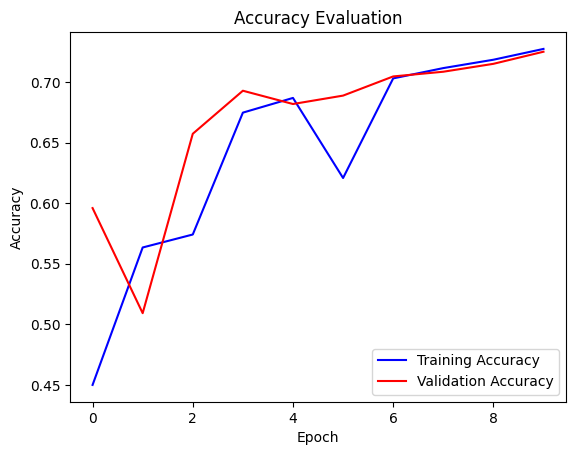

In [62]:
### Training and Validation accuracies
plt.plot(history_embedding.history['accuracy'], color="blue", label="Training Accuracy")
plt.plot(history_embedding.history['val_accuracy'], color="red", label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.title("Accuracy Evaluation")
plt.show()

### Plotting error or loss

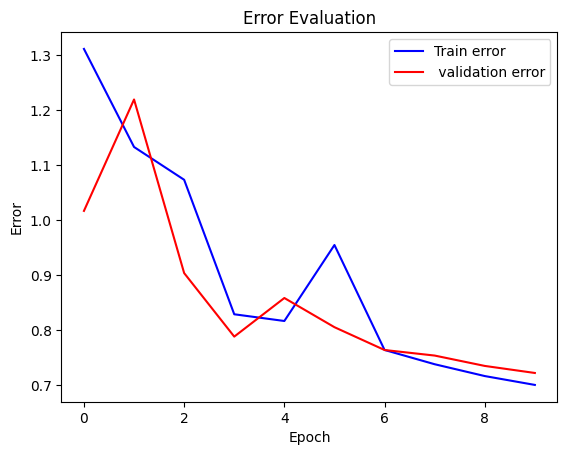

In [63]:
### Training and Validation Losses
plt.plot(history_embedding.history["loss"], color="blue", label="Train error")
plt.plot(history_embedding.history["val_loss"], color="red", label=" validation error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.title("Error Evaluation")
plt.show()

### Accurac, confusion Matrix, and Classification report(precision, recall, f1 score)

In [83]:
### train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.3, stratify=data_new.category, random_state=42)
print("y_test shape:", y_test.shape)

y_test shape: (7200, 6)


225/225 [==============================] - 6s 25ms/step
Accuracy: 0.7251388888888889
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      1200
           1       0.98      0.97      0.97      1200
           2       0.69      0.81      0.74      1200
           3       0.75      0.85      0.79      1200
           4       0.56      0.33      0.42      1200
           5       0.53      0.68      0.59      1200

    accuracy                           0.73      7200
   macro avg       0.73      0.73      0.72      7200
weighted avg       0.73      0.73      0.72      7200

Confusion Matrix:
[[ 869   13   37   38   30   14]
 [   6 1159    2   10    5    4]
 [  83    6  967   35  225   88]
 [  61   15   40 1016   61  170]
 [  97    5   78   21  396  110]
 [  84    2   76   80  483  814]]


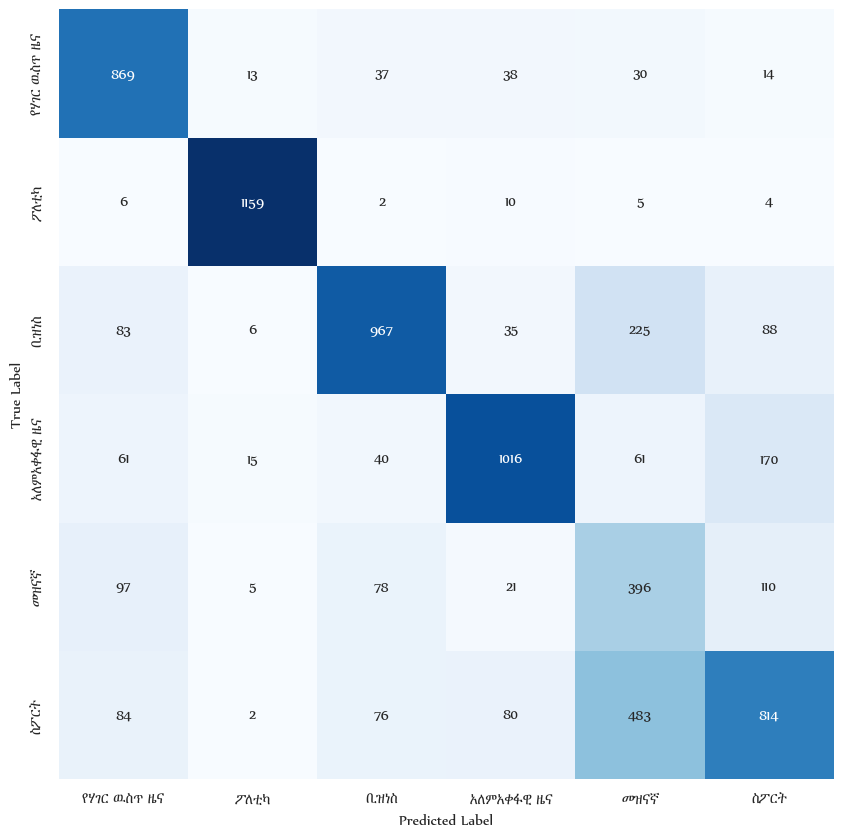

In [84]:
### When re-run this code, please run the above code first (### train_test_split)

### Accurac, confusion Matrix, and Classification report(precision, recall, f1 score)
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

prediction = model1.predict(X_test_pad)
y_pred = np.argmax(prediction, axis=-1)  # Get the predicted class labels
y_test = np.argmax(y_test, axis=-1)  # Convert one-hot encoded y_test back to class labels

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

labels = ['የሃገር ዉስጥ ዜና', 'ፖለቲካ', 'ቢዝነስ', 'አለምአቀፋዊ ዜና', 'መዝናኛ', 'ስፖርት']

cm = confusion_matrix(y_pred, y_test )
plt.figure(figsize=(10, 10))

font_name = "Nyala"
sn.set(font=font_name)
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("Confusion Matrix:")
print(cm)


### Spliting data for Bidirectional LSTM Model

In [95]:
### train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.3, stratify=data_new.category, random_state=42)

In [96]:
# to assign an index number for each uinque word we will use the follwing code
from keras.preprocessing.text import Tokenizer
vocab_size = vocab_size
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(data_new_stopwords_removed)
word_index = tokenizer.word_index
print(len(word_index))

62983


In [97]:
# Converting text to sequences...used for converting each word to number or vector space
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [98]:
# to get the maximum length of the sentences in the corpus
max_length= data_new['word_length'].max()
max_length

75

In [99]:
# Padding the sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
padding_type='post' ## adding 0s to the end of the sentences
truncation_type='post'
X_train_pad = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type,truncating=truncation_type)
X_test_pad = pad_sequences(X_test_sequences,maxlen=max_length, padding=padding_type, truncating=truncation_type)

In [90]:
(X_train_pad.shape, y_train.shape)

((17997, 75), (17997, 6))

In [100]:
#Creating the Keras embedding layer

from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense, Bidirectional

embedding_layer = Embedding(input_dim=len(word_index) + 1,# I didnt know why the length of word indexb became 1080?? thats why i added 247 to make it equal with 1327
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

### 2. Bidirectional LSTM

In [130]:
## 2. Bidirectional LSTM
model2=tf.keras.Sequential()
model2.add(embedding_layer)
model2.add(tf.keras.layers.Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)))
model2.add(tf.keras.layers.Bidirectional(LSTM(128)))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dense(6, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 75, 100)           6298400   
                                                                 
 bidirectional_6 (Bidirectio  (None, 75, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 6)                

In [131]:
history_embedding2=model2.fit(X_train_pad, y_train,batch_size=32,epochs=10,verbose=1, validation_data=(X_test_pad, y_test),validation_split=0.1)
model2.save('Bidirectional_LSTM_model.h5')
print('saved model')

Epoch 1/10
525/525 [==============================] - 78s 135ms/step - loss: 0.8640 - accuracy: 0.6615 - val_loss: 0.7459 - val_accuracy: 0.7171
Epoch 2/10
525/525 [==============================] - 75s 143ms/step - loss: 0.7321 - accuracy: 0.7118 - val_loss: 0.7255 - val_accuracy: 0.7208
Epoch 3/10
525/525 [==============================] - 87s 166ms/step - loss: 0.6884 - accuracy: 0.7320 - val_loss: 0.6932 - val_accuracy: 0.7301
Epoch 4/10
525/525 [==============================] - 76s 144ms/step - loss: 0.6528 - accuracy: 0.7456 - val_loss: 0.6928 - val_accuracy: 0.7329
Epoch 5/10
525/525 [==============================] - 76s 145ms/step - loss: 0.6267 - accuracy: 0.7553 - val_loss: 0.6534 - val_accuracy: 0.7485
Epoch 6/10
525/525 [==============================] - 73s 139ms/step - loss: 0.6081 - accuracy: 0.7636 - val_loss: 0.6630 - val_accuracy: 0.7451
Epoch 7/10
525/525 [==============================] - 71s 135ms/step - loss: 0.5828 - accuracy: 0.7693 - val_loss: 0.6643 - val_ac

In [71]:
X_train_pad.shape
y_train.shape

(14400, 4)

In [132]:
# Evaluate the model
loss, accuracy = model2.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

225/225 [==============================] - 7s 29ms/step - loss: 0.6500 - accuracy: 0.7546
Test Loss: 0.6500, Test Accuracy: 0.7546


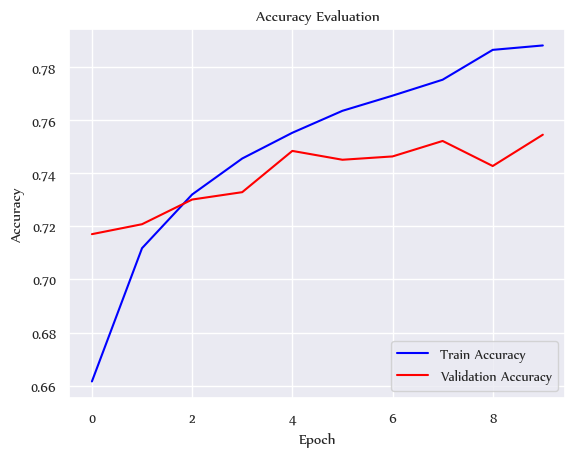

In [133]:
### Training and Validation accuracies
plt.plot(history_embedding2.history['accuracy'], color="blue", label="Train Accuracy")
plt.plot(history_embedding2.history['val_accuracy'], color="red", label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.title("Accuracy Evaluation")
plt.show()

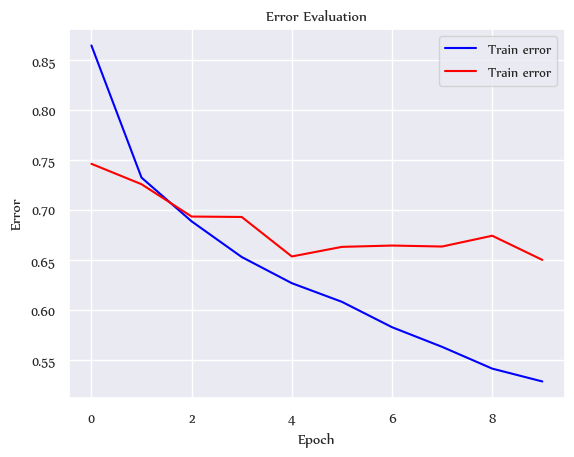

In [134]:
### Training and Validation Losses
plt.plot(history_embedding2.history["loss"], color="blue", label="Train error")
plt.plot(history_embedding2.history["val_loss"], color="red", label="Train error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.title("Error Evaluation")
plt.show()

### Accurac, confusion Matrix, and Classification report(precision, recall, f1 score)

In [135]:
### train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.3, stratify=data_new.category, random_state=42)

225/225 [==============================] - 7s 29ms/step
Accuracy: 0.7545833333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1200
           1       0.98      0.98      0.98      1200
           2       0.73      0.81      0.77      1200
           3       0.80      0.86      0.83      1200
           4       0.66      0.40      0.50      1200
           5       0.55      0.72      0.62      1200

    accuracy                           0.75      7200
   macro avg       0.76      0.75      0.75      7200
weighted avg       0.76      0.75      0.75      7200

Confusion Matrix:
[[ 912    9   50   30   46   30]
 [   7 1174    1   11    2    5]
 [  70    2  974   25  181   85]
 [  55   14   34 1035   50  113]
 [  78    1   48   14  476  105]
 [  78    0   93   85  445  862]]


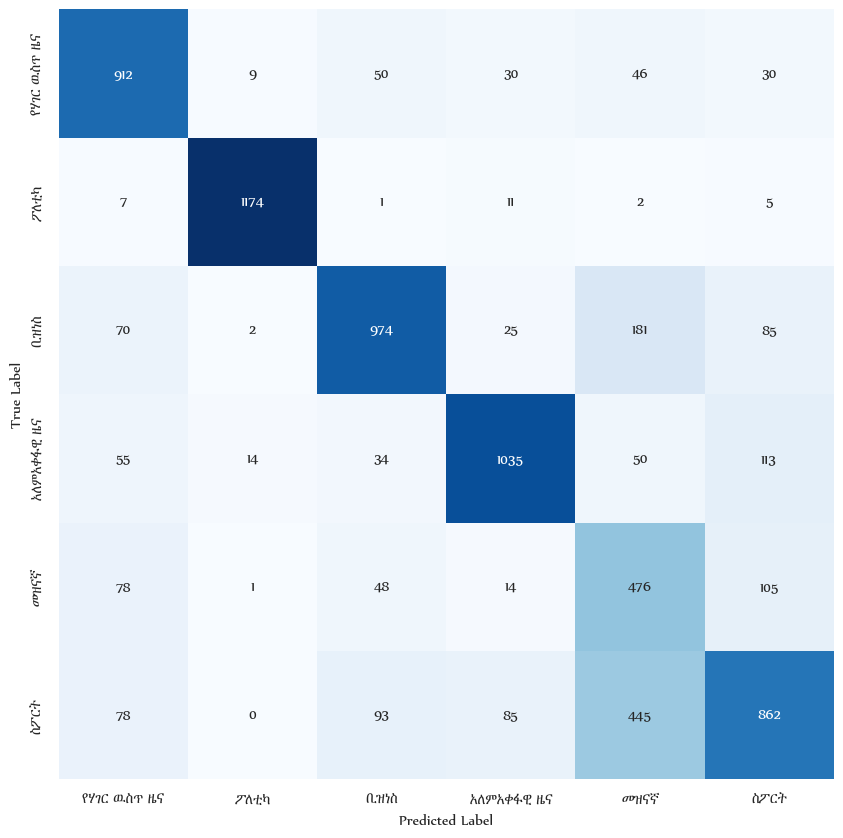

In [136]:
### When re-run this code, please run the above code first (### train_test_split)

### Accurac, confusion Matrix, and Classification report(precision, recall, f1 score)
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

prediction = model2.predict(X_test_pad)
y_pred = np.argmax(prediction, axis=-1)  # Get the predicted class labels
y_test = np.argmax(y_test, axis=-1)  # Convert one-hot encoded y_test back to class labels

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

labels = ['የሃገር ዉስጥ ዜና', 'ፖለቲካ', 'ቢዝነስ', 'አለምአቀፋዊ ዜና', 'መዝናኛ', 'ስፖርት']

cm = confusion_matrix(y_pred, y_test )
plt.figure(figsize=(10, 10))

font_name = "Nyala"
sn.set(font=font_name)
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("Confusion Matrix:")
print(cm)

### 3. Gated Recurrent Unit (GRU model)

#### Spliting data for Bidirectional LSTM Model

In [137]:
### train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.3, stratify=data_new.category, random_state=42)

In [138]:
# to assign an index number for each uinque word we will use the follwing code
from keras.preprocessing.text import Tokenizer
vocab_size = vocab_size
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(data_new_stopwords_removed)
word_index = tokenizer.word_index
print(len(word_index))

62983


In [139]:
# Converting text to sequences...used for converting each word to number or vector space
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [118]:
# to get the maximum length of the sentences in the corpus
max_length= data_new['word_length'].max()
max_length

75

In [119]:
# Padding the sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
padding_type='post' ## adding 0s to the end of the sentences
truncation_type='post'
X_train_pad = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type,truncating=truncation_type)
X_test_pad = pad_sequences(X_test_sequences,maxlen=max_length, padding=padding_type, truncating=truncation_type)

In [120]:
(X_train_pad.shape, y_train.shape)

((16797, 75), (16797, 6))

In [121]:
#Creating the Keras embedding layer

from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense, Bidirectional

embedding_layer = Embedding(input_dim=len(word_index) + 1,# I didnt know why the length of word indexb became 1080?? thats why i added 247 to make it equal with 1327
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

### GRU Model Building

In [140]:
### GRU Model
model3 = tf.keras.Sequential()
model3.add(embedding_layer)
model3.add(tf.keras.layers.GRU(64, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model3.add(tf.keras.layers.GRU(64))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(64, activation='relu'))
model3.add(tf.keras.layers.Dense(6, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()  

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 75, 100)           6298400   
                                                                 
 gru_6 (GRU)                 (None, 75, 64)            31872     
                                                                 
 gru_7 (GRU)                 (None, 64)                24960     
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 6)                 390       
                                                                 
Total params: 6,359,782
Trainable params: 61,382
Non-t

In [142]:
history_embedding3=model3.fit(X_train_pad, y_train,batch_size=32,epochs=10,verbose=1, validation_data=(X_test_pad, y_test),shuffle=True,validation_split=0.1)
model3.save('GRU.h5')
print('saved model')

Epoch 1/10
525/525 [==============================] - 31s 59ms/step - loss: 1.7921 - accuracy: 0.1651 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 2/10
525/525 [==============================] - 31s 58ms/step - loss: 1.7919 - accuracy: 0.1598 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 3/10
525/525 [==============================] - 31s 58ms/step - loss: 1.7918 - accuracy: 0.1637 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 4/10
525/525 [==============================] - 30s 57ms/step - loss: 1.7918 - accuracy: 0.1630 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 5/10
525/525 [==============================] - 30s 57ms/step - loss: 1.7918 - accuracy: 0.1606 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 6/10
525/525 [==============================] - 30s 57ms/step - loss: 1.7918 - accuracy: 0.1624 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 7/10
525/525 [==============================] - 31s 59ms/step - loss: 1.7918 - accuracy: 0.1628 - val_loss: 1.7918 - val_accuracy:

In [143]:
# Evaluate the model
loss, accuracy = model3.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

225/225 [==============================] - 3s 12ms/step - loss: 1.7918 - accuracy: 0.1667
Test Loss: 1.7918, Test Accuracy: 0.1667


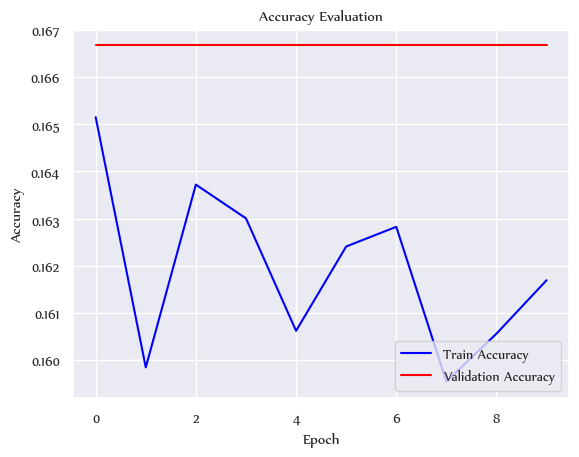

In [145]:
### Training and Validation accuracies
plt.plot(history_embedding3.history['accuracy'], color="blue", label="Train Accuracy")
plt.plot(history_embedding3.history['val_accuracy'], color="red", label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.title("Accuracy Evaluation")
plt.show()

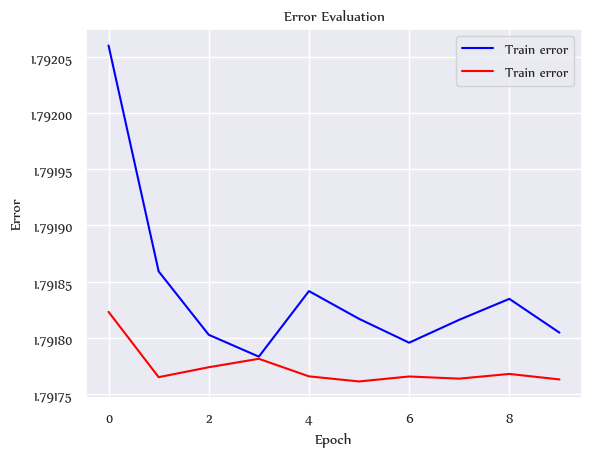

In [146]:
### Training and Validation Losses
plt.plot(history_embedding3.history["loss"], color="blue", label="Train error")
plt.plot(history_embedding3.history["val_loss"], color="red", label="Train error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.title("Error Evaluation")
plt.show()

### Accurac, confusion Matrix, and Classification report(precision, recall, f1 score)


In [147]:
### train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.3, stratify=data_new.category, random_state=42)

225/225 [==============================] - 3s 12ms/step
Accuracy: 0.16666666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.17      1.00      0.29      1200
           1       0.00      0.00      0.00      1200
           2       0.00      0.00      0.00      1200
           3       0.00      0.00      0.00      1200
           4       0.00      0.00      0.00      1200
           5       0.00      0.00      0.00      1200

    accuracy                           0.17      7200
   macro avg       0.03      0.17      0.05      7200
weighted avg       0.03      0.17      0.05      7200

Confusion Matrix:
[[1200 1200 1200 1200 1200 1200]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]]


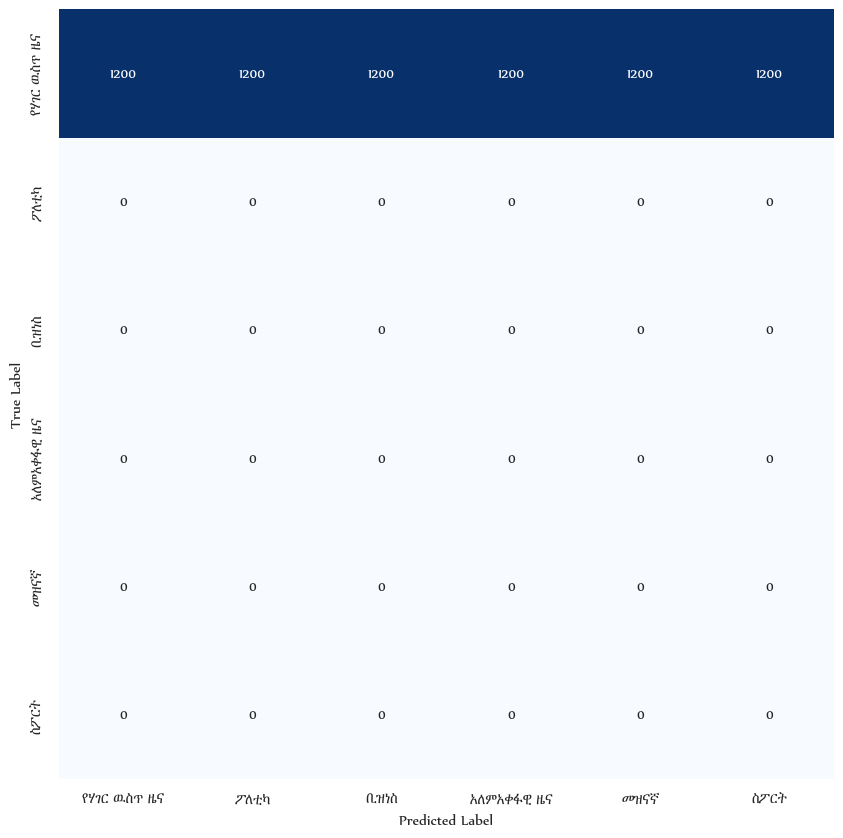

In [148]:
### When re-run this code, please run the above code first (### train_test_split)

### Accurac, confusion Matrix, and Classification report(precision, recall, f1 score)
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

prediction = model3.predict(X_test_pad)
y_pred = np.argmax(prediction, axis=-1)  # Get the predicted class labels
y_test = np.argmax(y_test, axis=-1)  # Convert one-hot encoded y_test back to class labels

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

labels = ['የሃገር ዉስጥ ዜና', 'ፖለቲካ', 'ቢዝነስ', 'አለምአቀፋዊ ዜና', 'መዝናኛ', 'ስፖርት']

cm = confusion_matrix(y_pred, y_test )
plt.figure(figsize=(10, 10))

font_name = "Nyala"
sn.set(font=font_name)
sn.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("Confusion Matrix:")
print(cm)

### 4. Word2vec